## Problem 6.3: Analysis of FRAP data (40 pts)¶

Attribution: Zhiyang and Xinhong did the coding, the whole group discussed together about the models and methods.

In [142]:
import numpy as np
import pandas as pd
import scipy.special
import scipy.stats as st
import statsmodels.tools.numdiff as smnd

import bebi103

import altair as alt
import bokeh.io
bokeh.io.output_notebook()

Loading BokehJS ...

The model given by the problem set:

\begin{align}
I_\mathrm{norm}(t) \equiv I(t)/I_0 &= 
f_f\left(1 - f_b\,\frac{4 \mathrm{e}^{-k_\mathrm{off}t}}{d_x d_y}\,\psi_x(t)\,\psi_y(t)\right),\\[1mm]
\text{where } \psi_i(t) &= \frac{d_i}{2}\,\mathrm{erf}\left(\frac{d_i}{\sqrt{4Dt}}\right)
-\sqrt{\frac{D t}{\pi}}\left(1 - \mathrm{e}^{-d_i^2/4Dt}\right),
\end{align}

In [65]:
# Turn the equation of the model into code:

def fluo_bleach_psi(dx, D, t):
    return dx / 2 * scipy.special.erf(dx / np.sqrt(4 * D * t)) - \
           np.sqrt(D * t / np.pi) * (1 - np.exp(-np.power(dx,2) / (4 * D * t)))

def fluo_bleach_cal(t, f_b, f_f, k_off, D, dx=40*0.138, dy=40*0.138):
    if t < 0:
        return 1
    elif t == 0:
        return f_f * (1 - f_b)
    else:
        psi_x = fluo_bleach_psi(dx, D, t)
        psi_y = fluo_bleach_psi(dy, D, t)
        return f_f * (1 - f_b * 4 * np.exp(-k_off * t) / (dx * dy) * psi_x * psi_y)

In [66]:
fluo_bleach_cal(0,0.9,0.9,1,1)

0.08999999999999998

Let's read in the data and take a look

In [67]:
# read in the dataset
df = pd.read_csv('../data/hw_4.1_frap_image_processing_results.csv')
df.head()

,mean_intensity,time,trial,normalized_intensity
0,786.469375,-3.760,0,1.014676
1,766.556875,-3.572,0,0.988986
2,777.139375,-3.384,0,1.002639
3,787.697500,-3.196,0,1.016261
4,769.598750,-3.008,0,0.992910


First let's plot the data and get an idea of how it looks.

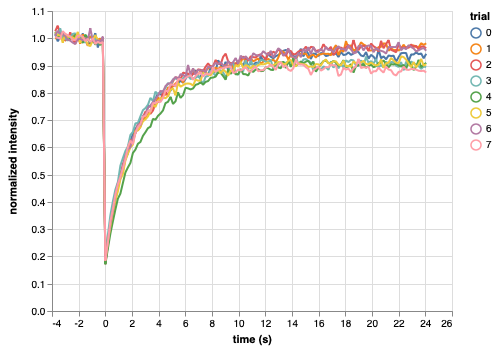

In [68]:
# Plot all the trials
alt.Chart(df
    ).mark_line(
        strokeJoin='bevel'
    ).encode(
        x=alt.X('time:Q', title='time (s)'),
        y=alt.Y('normalized_intensity:Q', title='normalized intensity'),
        color='trial:N',
        order='time:Q'
    )

After looking at the data and consider the definition of paramters, we hypothesize the distribution of different parameters:  
We think the data in general would follow a normal distribution Normal(fluo_bleach_cal(t0, fb, ff, k_off, D), sigma) 

fb is the fraction of bleached fluorophores, it has the bound of 0~1, and it shold be close to 1, so we speculate it would follow a beta distribution.  
ff is the fraction of total fluorescent species left after photobleaching, it would be similar to fb, should also follow beta distribution.  
D is the diffusion coefficent, we assume it could be similar across trials, which indicates  a sharp peak, also it has a lower bound (0), but not an upper bound. So lognormal distribution would best to describe D.  
k_off is chemical rate constant, the situation is similar to D, so it should also lies in a lognormal distribution.  
sigma usually follows a normal distribution.  


After getting the general idea of distribution of each parameters, let's specify each paramters:




In [69]:
# Specify the distributions for each paramters in the model
def data_prior_pred(t, n_ppc_samples=1):
    '''
    Samples parameter values according to the prior and generates
    data y at the values given in x.
    '''
    sigma = np.abs(np.random.normal(0, 0.01, size=n_ppc_samples))
    k_off = np.random.lognormal(np.log(0.2), 0.5, size=n_ppc_samples)
    D = np.random.lognormal(np.log(0.1), 0.75, size=n_ppc_samples)
    fb = np.random.beta(6, 3, size=n_ppc_samples)
    ff = np.random.beta(15, 2, size=n_ppc_samples)
    
    data = np.array([np.random.normal(fluo_bleach_cal(t0, fb, ff, k_off, D),
                                      sigma, size=1) 
                        for t0 in t])
    return np.concatenate(data)

In summary, our prior is:
$$data\sim Normal(fluobleachcal(t0, fb, ff, k_off, D), sigma, size=1)$$ 

$$fb\sim Beta(6,3)$$
$$ff\sim Beta(15,2)$$
$$D\sim Lognormal(np.log(0.1), 0.75)$$
$$koff\sim Lognormal(np.log(0.2), 0.5)$$
$$sigma\sim normal(0, 0.01)$$


Let's use Trial0 to do a prior predictive check!

In [70]:
# Slice out the data belongs to trial0
t0 = df.loc[df['trial']==0, 'time'].values
v0 = df.loc[df['trial']==0, 'normalized_intensity'].values

In [71]:
# prior check use the data in trial0
colors = bokeh.palettes.all_palettes['Category20'][20]

p = bokeh.plotting.figure(height=300, width=450,
                          x_axis_label='time(s)',
                          y_axis_label='intensity')

# Plot simulated data
for i in range(20):
    p.line(t0, data_prior_pred(t0), color=colors[i],
             alpha=0.8)

# Plot original data
p.circle(t0, v0, color='black', size=4)
bokeh.io.show(p)

The black dots are the original data we acquired from the dataset, the colored lines are the simulated data generated from our prior. We could see that our prior cover most of the real data, which indicates our prior seems reasonable. However, since we are going to use this same prior for all the trials, it is possible that they didn't fit with the data in other trial very well, so when we do prior check for each trial, we may have to go back to tune the parameters of our model. But let's move on to following analysis of Trial0 with this prior now.

Let's specify the likelihood and caculate the posterior.And we would like to aquire the log-likelihood and log-prior to caculate the log-posterior.

In [72]:
# Specify the log_prior
def log_prior(params):
    
    if (params < 0).any():
        return -np.inf
    
    fb, ff, k_off, D, sigma = params

    log_prior = st.beta.logpdf(fb, 6, 3)
    log_prior += st.beta.logpdf(ff, 15, 1)
    log_prior += st.lognorm.logpdf(k_off, 0.5, loc=0, scale=0.2)
    log_prior += st.lognorm.logpdf(D, 0.75, loc=0, scale=0.3)
    log_prior += st.halfnorm.logpdf(sigma, 0, 0.01)
    
    return log_prior

# Specify the log_likelihood
def log_like(params, t, y):
    fb, ff, k_off, D, sigma = params
    
    log_like = np.sum([st.norm.logpdf(y0, fluo_bleach_cal(t0, fb, ff, k_off, D), sigma)
                       for y0, t0 in zip(y, t)])
    
    return log_like

In [73]:
# Calculate the posterior using the prior and likelihood
def log_post(params, t, y):
    return log_prior(params) + log_like(params, t, y)

def neg_log_post(params, t, y):
    return -log_post(params, t, y)

Since we have 5 paramters in total, it's hard to plot the posterior. So we will directly go ahead and find the Map values.  
After several trial of find Map_values using different methods, we find that 'SLSQP' works the best for us. We are not quite sure about why this method works but not the others. For instance, when we use 'Powell' method Justin used in Tutorial, it gives us some weird number larger than 200.

In [74]:
# Specify arguments
args_0 = (t0, v0)

# Choose initial conditiona
params_0 = [0.9, 0.9, 0.2, 0.3, 0.01]

# Compute the MAP values
opt_res_0 = scipy.optimize.minimize(neg_log_post, params_0, args=args_0,
                                    method='SLSQP')

/Users/chenxinhong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.
/Users/chenxinhong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


In [75]:
# Take a look at the Map values 
popt_0 = opt_res_0.x
print(popt_0)

[0.83928361 0.93895569 0.25985803 0.35063933 0.01314211]


These paramter values look reasonable based on the definition of parameters and our intuition for their distribution. So let's plug these paramters into our model and plot the simulated line using the data sample from this generative model. And we could also plot the measured data in the same plot to compare the difference.

In [76]:
# Do a posterior check with the real data

# Plug in the paramters we get and generate some simulated data
def data_prior_pred_0(t, n_ppc_samples=1):
    fb, ff, k_off, D, sigma = popt_0
    data = np.array([np.random.normal(fluo_bleach_cal(t0, fb, ff, k_off, D),
                                      sigma, size=1) 
                        for t0 in t])
    return np.concatenate(data)


colors = bokeh.palettes.all_palettes['Category20'][20]

p = bokeh.plotting.figure(height=300, width=450,
                          x_axis_label='time(s)',
                          y_axis_label='intensity')

# Plot simulated data for 20 'simulated trials'
for i in range(20):
    p.line(t0, data_prior_pred_0(t0), color=colors[i],
             alpha=0.8)

# Plot original data
p.circle(t0, v0, color='black', size=4)
bokeh.io.show(p)

The black dots are the original data we acquired from the dataset, the colored lines are the simulated data generated from our posterior. We could see they fit with each other quite well, indicating that our estimation of paramters are quite reasonable. So let's move on and calculate the 95% confidence interval for these paramters.

In [77]:
hes = smnd.approx_hess(popt_0, log_post, args=args_0)

# Compute the covariance matrix
cov = -np.linalg.inv(hes)

# Look at it
for i in range(5):
    print(abs(cov[i][i]))
    

0.00016911904354358466
3.5268303496668336e-06
0.0004684908856278591
0.00944923475285257
5.669628436172438e-07


In [78]:
# For convenience...
fb_MAP_0, ff_MAP_0, k_off_MAP_0, D_MAP_0, sigma_MAP_0  = popt_0

# Print results
print("""
Most probable parameters for Trial0
-----------------------------------
fb_MAP_0 = {0:.2f} ± {1:.2f} 
ff_MAP_0 = {2:.3f} ± {3:.3f}
k_off_MAP_0 = {4:.3f} ± {5:.3f}
D_MAP_0 = {6:.3f} ± {7:.3f}
sigma_MAP_0 = {8:.3f} ± {9:.3f}
""".format(fb_MAP_0, 2* np.sqrt(abs(cov[0, 0])), 
           ff_MAP_0, 2* np.sqrt(abs(cov[1, 1])), 
           k_off_MAP_0, 2* np.sqrt(abs(cov[2, 2])),
           D_MAP_0, 2* np.sqrt(abs(cov[3, 3])),
           sigma_MAP_0, 2* np.sqrt(abs(cov[4, 4]))))


Most probable parameters for Trial0
-----------------------------------
fb_MAP_0 = 0.84 ± 0.03 
ff_MAP_0 = 0.939 ± 0.004
k_off_MAP_0 = 0.260 ± 0.043
D_MAP_0 = 0.351 ± 0.194
sigma_MAP_0 = 0.013 ± 0.002



We get the values of the paramters and their 95% confidence interval! They looks fairy reasonable. Let's do the simailar analysis on all the other trials.   
To perform the similar method on all the trial, we would like to summarize the function into several blocks, and call the block for each trail to perform all the operation.

In [79]:
# Function to do prior check

def slice_data_prior_check(i):
    ti = df.loc[df['trial']==i, 'time'].values
    vi = df.loc[df['trial']==i, 'normalized_intensity'].values
    
    colors = bokeh.palettes.all_palettes['Category20'][20]

    p1 = bokeh.plotting.figure(height=300, width=450,
                              x_axis_label='time(s)',
                              y_axis_label='intensity',
                              title = 'prior')

    # Plot simulated data
    for i in range(20):
        p1.line(ti, data_prior_pred(ti), color=colors[i],
               alpha=0.8)

    # Plot original data
    p1.circle(ti, vi, color='black', size=4)
    
    
    return ti, vi, p1
   

In [80]:
# Function to compute Map_values

def compute_Map_values(i, ti, vi, params_i):
      # Specify arguments
        args_i = (ti, vi)
    
      # Choose initial condition
        params = params_i

     # Compute the MAP values
        opt_res_i = scipy.optimize.minimize(neg_log_post, params, args=args_i,
                                            method='SLSQP')

        #popt_i = opt_res_i.x
        
        #return Map_values
        return opt_res_i.x

In [81]:
# Function to plot the simulated line based on posterior and original data

def data_prior_pred_back(ti, n_ppc_samples=1):
        fb, ff, k_off, D, sigma = popt_i
        data = np.array([np.random.normal(fluo_bleach_cal(t, fb, ff, k_off, D),
                                          sigma, size=1) 
                                           for t in ti])
        return np.concatenate(data)


def plot_best_fit_line(i, ti, vi, popt_i):
    
    
    colors = bokeh.palettes.all_palettes['Category20'][20]

    p2 = bokeh.plotting.figure(height=300, width=450,
                              x_axis_label='time(s)',
                              y_axis_label='intensity',
                              title = 'posterior')

    # Plot simulated data
    for i in range(20):
        p2.line(ti, data_prior_pred_back(ti), color=colors[i],
               alpha=0.8)

    # Plot original data
    p2.circle(ti, vi, color='black', size=4)
    
    return p2
    

In [82]:
# FUnction to compute the 95% confidence interval for the paramters

def present_parameter_with_95(i, popt_i, args_i):
    hes = smnd.approx_hess(popt_i, log_post, args=args_i,  epsilon=1e-8)
    
    # Compute the covariance matrix
    cov = -np.linalg.inv(hes)

    # Print results
    print("Trial", i)
    print("""
    Most probable parameters 
    ------------------------
    fb_MAP = {0:.2f} ± {1:.2f} 
    ff_MAP = {2:.3f} ± {3:.3f}
    k_off_MAP = {4:.3f} ± {5:.3f}
    D_MAP = {6:.3f} ± {7:.3f}
    sigma_MAP = {8:.3f} ± {9:.3f}
    
    --------------------------------------------
    """.format(popt_i[0], 2* np.sqrt(abs(cov[0, 0])), 
               popt_i[1], 2* np.sqrt(abs(cov[1, 1])), 
               popt_i[2], 2* np.sqrt(abs(cov[2, 2])),
               popt_i[3], 2* np.sqrt(abs(cov[3, 3])),
               popt_i[4], 2* np.sqrt(abs(cov[4, 4]))))

    #return fb, ff, k_off, D, sigma
    return [popt_i[0], 2* np.sqrt(abs(cov[0, 0]))], [popt_i[1], 2* np.sqrt(abs(cov[1, 1]))], [popt_i[2], 2* np.sqrt(abs(cov[2, 2]))], [popt_i[3], 2* np.sqrt(abs(cov[3, 3]))], [popt_i[4], 2* np.sqrt(abs(cov[4, 4]))] 

After building the function blocks we need for the analysis, since we already performed analysis on Trial0, let's test the function with Trial0 to make sure nothing everything is good. 

In [83]:
# Run the function blocks on Trial0
for i in range(0,1):
    ti, vi, p1 = slice_data_prior_check(i)
    popt_i = compute_Map_values(i, ti, vi, [0.9, 0.9, 0.2, 0.3, 0.01])
    args_i = (ti, vi)
    p2 = plot_best_fit_line(i, ti, vi, popt_i)
    result_i = present_parameter_with_95(i, popt_i, args_i)
    fb = result_i[0][:]
    ff = result_i[1][:]
    k_off = result_i[2][:]
    D = result_i[3][:]
    sigma = result_i[4][:]
    
    bokeh.io.show(bokeh.layouts.gridplot([p1, p2], ncols=2))


/Users/chenxinhong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.
/Users/chenxinhong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


Trial 0

    Most probable parameters 
    ------------------------
    fb_MAP = 0.84 ± 0.03 
    ff_MAP = 0.939 ± 0.004
    k_off_MAP = 0.260 ± 0.044
    D_MAP = 0.351 ± 0.198
    sigma_MAP = 0.013 ± 0.002
    
    --------------------------------------------
    


The black dots in both graphs are the measured data. Left graphs plot the simulated data from prior, right graphs plot simulated data from posterior. The result is the same as what we get from direct operation on trial0, let's move on and use this on other trials.

In [84]:
for i in range(1,8):
    ti, vi, p1 = slice_data_prior_check(i)
    popt_i = compute_Map_values(i, ti, vi, [0.9, 0.9, 0.2, 0.3, 0.01])
    args_i = (ti, vi)
    p2 = plot_best_fit_line(i, ti, vi, popt_i)
    result_i = present_parameter_with_95(i, popt_i, args_i)
    fb = np.vstack([fb, result_i[0][:]])
    ff = np.vstack([ff, result_i[1][:]])
    k_off = np.vstack([k_off, result_i[2][:]])
    D = np.vstack([D, result_i[3][:]])
    sigma = np.vstack([sigma, result_i[4][:]])
    bokeh.io.show(bokeh.layouts.gridplot([p1, p2], ncols=2))

/Users/chenxinhong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.
/Users/chenxinhong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


Trial 1

    Most probable parameters 
    ------------------------
    fb_MAP = 0.86 ± 0.02 
    ff_MAP = 0.965 ± 0.005
    k_off_MAP = 0.137 ± 0.020
    D_MAP = 0.803 ± 0.126
    sigma_MAP = 0.013 ± 0.001
    
    --------------------------------------------
    


/Users/chenxinhong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in double_scalars
  from ipykernel import kernelapp as app


Trial 2

    Most probable parameters 
    ------------------------
    fb_MAP = 0.98 ± 0.01 
    ff_MAP = 1.000 ± 0.013
    k_off_MAP = 0.028 ± 0.014
    D_MAP = 1.923 ± 0.148
    sigma_MAP = 0.025 ± 0.003
    
    --------------------------------------------
    


Trial 3

    Most probable parameters 
    ------------------------
    fb_MAP = 0.78 ± 0.02 
    ff_MAP = 0.904 ± 0.003
    k_off_MAP = 0.362 ± 0.026
    D_MAP = 0.221 ± 0.075
    sigma_MAP = 0.014 ± 0.002
    
    --------------------------------------------
    


Trial 4

    Most probable parameters 
    ------------------------
    fb_MAP = 0.82 ± 0.02 
    ff_MAP = 0.906 ± 0.003
    k_off_MAP = 0.272 ± 0.027
    D_MAP = 0.130 ± 0.087
    sigma_MAP = 0.011 ± 0.001
    
    --------------------------------------------
    


Trial 5

    Most probable parameters 
    ------------------------
    fb_MAP = 0.81 ± 0.02 
    ff_MAP = 0.910 ± 0.003
    k_off_MAP = 0.309 ± 0.020
    D_MAP = 0.187 ± 0.064
    sigma_MAP = 0.011 ± 0.001
    
    --------------------------------------------
    


Trial 6

    Most probable parameters 
    ------------------------
    fb_MAP = 0.83 ± 0.02 
    ff_MAP = 0.959 ± 0.003
    k_off_MAP = 0.240 ± 0.025
    D_MAP = 0.353 ± 0.109
    sigma_MAP = 0.012 ± 0.001
    
    --------------------------------------------
    


Trial 7

    Most probable parameters 
    ------------------------
    fb_MAP = 0.80 ± 0.02 
    ff_MAP = 0.891 ± 0.003
    k_off_MAP = 0.410 ± 0.027
    D_MAP = 0.080 ± 0.060
    sigma_MAP = 0.011 ± 0.001
    
    --------------------------------------------
    


After running through each trial, we would have a numpy array for each parameter, let's look at all the paramter and plot the jitter plot for all the paramters with 95% confidence interval.


In [119]:
# Take a look at fb
print("fb[value, 95%interval]:", '\n', fb)

fb[value, 95%interval]: 
 [[0.83928361 0.02555707]
 [0.86129599 0.02055443]
 [0.98474978 0.01350626]
 [0.78474126 0.01918692]
 [0.82388568 0.02132988]
 [0.81036589 0.01578645]
 [0.82717563 0.01741692]
 [0.80021727 0.01933533]]


In [120]:
# Put the estimate for fb in every trial into a dataframe
fb_estimate = pd.DataFrame(data={'value': fb[:,0], '95%': fb[:,1]})
fb_estimate.insert(0, 'trial', range(0, 0 + len(fb_estimate)))
fb_estimate

,trial,value,95%
0,0,0.839284,0.025557
1,1,0.861296,0.020554
2,2,0.984750,0.013506
3,3,0.784741,0.019187
4,4,0.823886,0.021330
5,5,0.810366,0.015786
6,6,0.827176,0.017417
7,7,0.800217,0.019335


We would like to plot the estimate of fb with 95% confidence interval to get a better sense of the paramter.

In [1]:
#Plot the estimate of fb with 95% confidence interval

# Put the estimate for fb in every trial into a dataframe
fb_estimate = pd.DataFrame(data={'value': fb[:,0], '95%': fb[:,1]})
fb_estimate.insert(0, 'trial', range(0, 0 + len(fb_estimate)))
fb_estimate

# for convenience..
xs = fb_estimate['trial']
ys = fb_estimate['value']
yerss = fb_estimate['95%']

# plot the points
p_fb = bokeh.plotting.figure(height=300, width=450,
                              x_axis_label='trial',
                              y_axis_label='value',
                              title = 'estimate of fb with 95% confidence interval')

p_fb.circle(xs, ys, color='green', size=5, line_alpha=0)


# create the coordinates for the errorbars
err_xs = []
err_ys = []

for x, y, yerr in zip(xs, ys, yerrs):
    err_xs.append((x, x))
    err_ys.append((y - yerr, y + yerr))

# plot them
p_fb.multi_line(err_xs, err_ys, color='green')

bokeh.plotting.show(p_fb)

NameError: name 'pd' is not defined

Let's do the similar plot on the other parameters.

Plot the estimate of ff with 95% confidence interval:

In [126]:
#Plot the estimate of ff with 95% confidence interval

# Put the estimate for ff in every trial into a dataframe
ff_estimate = pd.DataFrame(data={'value': ff[:,0], '95%': ff[:,1]})
ff_estimate.insert(0, 'trial', range(0, 0 + len(ff_estimate)))
ff_estimate

# for convenience..
xs = ff_estimate['trial']
ys = ff_estimate['value']
yerss = ff_estimate['95%']

# plot the points
p_ff = bokeh.plotting.figure(height=300, width=450,
                              x_axis_label='trial',
                              y_axis_label='value',
                              title = 'estimate of ff with 95% confidence interval')

p_ff.circle(xs, ys, color='green', size=5, line_alpha=0)


# create the coordinates for the errorbars
err_xs = []
err_ys = []

for x, y, yerr in zip(xs, ys, yerrs):
    err_xs.append((x, x))
    err_ys.append((y - yerr, y + yerr))

# plot them
p_ff.multi_line(err_xs, err_ys, color='green')

bokeh.plotting.show(p_ff)

Plot the estimate of k_off with 95% confidence interval:

In [131]:
#Plot the estimate of k_off with 95% confidence interval

# Put the estimate for k_off in every trial into a dataframe
k_off_estimate = pd.DataFrame(data={'value': k_off[:,0], '95%': k_off[:,1]})
k_off_estimate.insert(0, 'trial', range(0, 0 + len(k_off_estimate)))
k_off_estimate

# for convenience..
xs = k_off_estimate['trial']
ys = k_off_estimate['value']
yerss = k_off_estimate['95%']

# plot the points
p_k_off = bokeh.plotting.figure(height=300, width=450,
                              x_axis_label='trial',
                              y_axis_label='value',
                              title = 'estimate of k_off with 95% confidence interval')

p_k_off.circle(xs, ys, color='blue', size=5, line_alpha=0)


# create the coordinates for the errorbars
err_xs = []
err_ys = []

for x, y, yerr in zip(xs, ys, yerrs):
    err_xs.append((x, x))
    err_ys.append((y - yerr, y + yerr))

# plot them
p_k_off.multi_line(err_xs, err_ys, color='blue')

bokeh.plotting.show(p_k_off)

Plot the estimate of D with 95% confidence interval:

In [139]:
#Plot the estimate of D with 95% confidence interval

# Put the estimate for D in every trial into a dataframe
D_estimate = pd.DataFrame(data={'value': D[:,0], '95%': D[:,1]})
D_estimate.insert(0, 'trial', range(0, 0 + len(D_estimate)))
D_estimate

# for convenience..
xs = D_estimate['trial']
ys = D_estimate['value']
yerss = D_estimate['95%']

# plot the points
p_D = bokeh.plotting.figure(height=300, width=450,
                              x_axis_label='trial',
                              y_axis_label='value',
                              title = 'estimate of D with 95% confidence interval')

p_D.circle(xs, ys, color='orange', size= 5, line_alpha=0)


# create the coordinates for the errorbars
err_xs = []
err_ys = []

for x, y, yerr in zip(xs, ys, yerrs):
    err_xs.append((x, x))
    err_ys.append((y - yerr, y + yerr))

# plot them
p_D.multi_line(err_xs, err_ys, color='black')

bokeh.plotting.show(p_D)

The error bar in D plot looks very small (the little black lines) because the scale.

Plot the estimate of sigma with 95% confidence interval:

In [134]:
#Plot the estimate of sigma with 95% confidence interval

# Put the estimate for sigma in every trial into a dataframe
sigma_estimate = pd.DataFrame(data={'value': sigma[:,0], '95%': sigma[:,1]})
sigma_estimate.insert(0, 'trial', range(0, 0 + len(sigma_estimate)))
sigma_estimate

# for convenience..
xs = sigma_estimate['trial']
ys = sigma_estimate['value']
yerss = sigma_estimate['95%']

# plot the points
p_sigma = bokeh.plotting.figure(height=300, width=450,
                              x_axis_label='trial',
                              y_axis_label='value',
                              title = 'estimate of sigma with 95% confidence interval')

p_sigma.circle(xs, ys, color='purple', size=5, line_alpha=0)


# create the coordinates for the errorbars
err_xs = []
err_ys = []

for x, y, yerr in zip(xs, ys, yerrs):
    err_xs.append((x, x))
    err_ys.append((y - yerr, y + yerr))

# plot them
p_sigma.multi_line(err_xs, err_ys, color='purple')

bokeh.plotting.show(p_sigma)

Let's show all the paramters together:

In [141]:
bokeh.io.show(bokeh.layouts.gridplot([p_fb, p_ff, p_k_off, p_D, p_sigma], ncols=2))

In [52]:
%load_ext watermark

In [54]:
%watermark -v -p numpy,pandas,statsmodels,altair,scipy,bokeh,jupyterlab

CPython 3.6.6
IPython 7.0.1

numpy 1.15.2
pandas 0.23.4
statsmodels 0.9.0
altair 2.2.2
scipy 1.1.0
bokeh 0.13.0
jupyterlab 0.35.0
